# Conditional Random Field For Image Segmentation 

In this notebook, we're going to demonstrate how to segment an image using conditional random fields (CRFs)

**Notebook layout**:
1. Load images
    - Load the image to be segmented
    - Load images to get class information: If there are k classes, load k images. Each of these images should depict only one specific class.
2. Segment image using CRF:
    - Initialise CRF
    - Calculate pairwise energy between pixels
    - Optimise the energy function to get lowest energy

In [2]:
!pip3 install imageio

    100% |████████████████████████████████| 3.3MB 1.3MB/s ta 0:00:01
pyinquirer 1.0.2 has requirement prompt-toolkit==1.0.14, but you'll have prompt-toolkit 2.0.7 which is incompatible.
rasa-core 0.10.1 has requirement networkx~=2.0, but you'll have networkx 1.11 which is incompatible.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# import the required libraries for image segmentation
from PIL import Image
import numpy as np
import pandas as pd
import os, os.path
from scipy import misc
import glob
import sys
from matplotlib.pyplot import imshow
import imageio
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import optimize
import random

import warnings
warnings.filterwarnings('ignore')

Original image


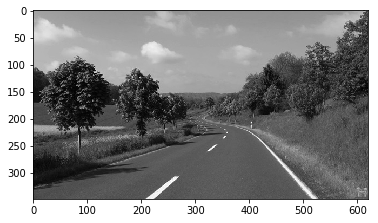

In [4]:
# load the image to be segmented
image_array = misc.imread("test2-mini.jpg", flatten=True)
print ("Original image")
imshow(image_array, cmap='gray');

In [5]:
# create an array of class information for each image
initial_probability = {"Sky.jpg": 0.30,"Road.jpg": 0.20, "Grass.jpg":0.50}
num_of_pixels = image_array.size
image_info = []
image_List= ["Sky.jpg", "Road.jpg", "Grass.jpg"]
for image in image_List:
    temp_arr = misc.imread(image, flatten=True)
    mean = np.mean(temp_arr)
    var = np.var(temp_arr)
    freq = len(temp_arr)
    probabilty = freq/num_of_pixels
    image_info.append([initial_probability[image], mean, var])

print ("image_info")
print (image_info)

image_info
[[0.3, 166.92361, 272.364], [0.2, 95.18236, 964.224], [0.5, 59.97941, 1128.2644]]


    Normal PDF

In [6]:
def calculate_normal_pdf(i, mean, var):
    return (1/np.sqrt(2 *  np.pi * var))*np.exp(-((i-mean)**2)/(2*var))

In [7]:
# the function performs label prediction using Naive Bayes for initialising the CRF model
def label_prediction (image_array, image_info, pixel_index=[],array_check = []):
    output_array = np.zeros((len(image_array), len(image_array[0])), dtype=float)
    image_color = [0,127,255]
    for i in range(0, len(image_array)):
        for j in range(0, len(image_array[0])): 
            if (len(pixel_index)>0 and len(array_check)>0 and pixel_index[i][j]==1):
                output_array[i][j]=array_check[i][j]
                continue
            max_prob = 0
            best_class = -1
            value = image_array[i][j]
            for index in range(len(image_info)):
                prior =  image_info[index][0]
                mean =  image_info[index][1]
                var = image_info[index][2]
                likelihood =calculate_normal_pdf(value, mean, var)
                posterior = prior * likelihood

                if (posterior > max_prob):
                    max_prob = posterior
                    best_class = index
            
            output_array[i][j] = image_color[best_class]
            
    return output_array

In [8]:
# the function computes distance between two pixels
def dist (i,j):
    x = i-j
    x = x*x
    return np.sqrt(np.sum(x))

In [9]:
# the function computes difference between two pixels
def diff(i,j):
    if (i==j):
        return -1
    else:
        return 1

In [10]:
# calculate the initial energy
def calculate_initial_energy(initial_weights, pixels, beta, info, indices_neighbors):
    w = initial_weights
    energy = 0.0
    rows = len(w)
    cols = len(w[0])
    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            mean = info[int (w[i][j])][1]
            var =  info[int (w[i][j])][2]
            energy += np.log(np.sqrt(2*np.pi*var)) 
            energy += ((pixels[i][j]-mean)**2)/(2*var)
            for a,b in indices_neighbors:
                a +=i
                b +=j
                if 0<=a<rows and 0<=b<cols:
                    energy += beta * diff(w[i][j], w[a][b])
    return energy

In [11]:
# calculate exponential schedule
def calculate_exponential_schedule(step_num, current_t, initial_temp,  constant=0.99):
    return current_t*constant

In [12]:
# calculate logarithmical multiplicative schedule
def calculate_logarithmical_multiplicative_schedule(step_num, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * np.log(1+step_num))

In [13]:
# calculate linear multiplicative schedule
def calculate_linear_multiplicative_schedule(step_num, current_t, initial_temp, constant=1.0):
    return initial_temp / (1 + constant * step_num)

In [14]:
# calculate energy of the image
def calculate_delta_energy(w, index, beta, new_val, indices_neighbors, pixels, info):
    initial_energy = 0 
    (i,j) = index
    rows = len(w)
    columns = len(w[0])
    mean = info[int(w[i][j])][1]
    var =  info[int(w[i][j])][2]
    initial_energy += np.log(np.sqrt(2*np.pi*var)) 
    initial_energy += ((pixels[i][j]-mean)**2)/(2*var)
    for a,b in indices_neighbors:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<columns:
            initial_energy += beta * diff(w[i][j], w[a][b])
    
    new_energy = 0
    mean = info[new_val][1]
    var =  info[new_val][2]
    new_energy += np.log(np.sqrt(2*np.pi*var)) 
    new_energy += ((pixels[i][j]-mean)**2)/(2*var)
   

    for a,b in indices_neighbors:
        a +=i
        b +=j
        if 0<=a<rows and 0<=b<columns:
            new_energy += beta * diff(new_val, w[a][b])


    return new_energy - initial_energy

In [15]:
# optimise energy function using simulated annealing
def simulated_annealing_function(init_weights, class_labels, temp_function,
                        pixels, beta, info, indices_neighbors, max_iter=10000,
                        initial_temp = 1000, known_index=[], correct_arr = [], temp_function_constant=None ):
    partial_pred=False
    if (len(known_index)>0 and len(correct_arr)>0):
        partial_pred=True

    w = np.array(init_weights)
    changed_array = np.zeros((len(w), len(w[0])))
    iter =0
    x = len(w)
    y = len(w[0])
    current_energy = calculate_initial_energy(w, pixels, beta, info, indices_neighbors)
    current_temp = initial_temp
    while (iter<max_iter):
        if (partial_pred):
            is_found=False
            while (is_found==False):
                i = random.randint(0, x-1)
                j = random.randint(0, y-1)
                if (known_index[i][j]==0):
                    is_found=True
        else:
            i = random.randint(0, x-1)
            j = random.randint(0, y-1)

        l = list(class_labels)
        l.remove(w[i][j])
        r = random.randint(0, len(l)-1)
        new_val = l[r]
        delta = calculate_delta_energy(w, (i,j), beta, new_val, indices_neighbors, pixels, info)

        r = random.uniform(0, 1)

        if (delta<=0):
            w[i][j]=new_val
            current_energy+=delta
            changed_array[i][j]+=1
            
        else:
            try:
                if (-delta / current_temp < -600):
                    k=0
                else:
                    k = np.exp(-delta / current_temp)
            except:
                k=0

            if r < k:
                
                w[i][j] = new_val
                current_energy += delta
                changed_array[i][j] += 1
        if (temp_function_constant!=None):
            current_temp = temp_function(iter, current_temp, initial_temp, constant =temp_function_constant)
        else:
            current_temp = temp_function(iter, current_temp, initial_temp)
        iter+=1
    return w, changed_array

In [16]:
# return class labels array corresponding to the image array
def class_labels_conversion(image_array, array_inv={0:0, 127:1, 255:2}):
    for i in range(0, len(image_array)):
        for j in range(0, len(image_array[0])):
            image_array[i][j] = array_inv[int(image_array[i][j])]

In [17]:
# calculate the accuracy of image label classification
def calculate_accuracy(image_array, labels):
    correct = 0
    for i in range(0, len(image_array)):
        for j in range(0, len(image_array[0])):
            if (labels[i][j]==int(image_array[i][j]/127)):
                correct+=1
    return correct/(len(image_array[0])*len(image_array))

In [18]:
# main function which performs image segmentation
def image_segmentation(image_array, info, max_iter=1000000,var = 10000,
                               beta = 100,
                               indices_neighbor = [[0,1],[0,-1],[1,0],[-1,0]],
                               labels = [0,1,2], 
                               color = [0,127,255], 
                               schedule= calculate_exponential_schedule,
                               temp_function_constant=None):

    fig, (ax1, ax2) = plt.subplots(1,2)

    

    ax1.set_title("Initial image")

    ax1.imshow(image_array, cmap='gray')


    rows = len(image_array)
    columns = len(image_array[0])

    class_info = info
    initial_array = label_prediction(image_array, class_info)
    
    class_labels_conversion(initial_array)
    
    w, output_array = simulated_annealing_function(initial_array, labels, schedule,
                                        image_array, beta, class_info, indices_neighbor, max_iter=max_iter)

    
    for i in range (0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = color[int (w[i][j])]

    ax2.set_title('Segmentation result using Conditional Random Fields')
    ax2.imshow(w, cmap='gray')
    plt.rcParams["figure.figsize"] = (20,3)
    
    plt.show()

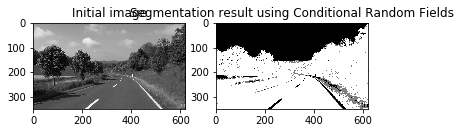

In [19]:
# set figure size
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')

# segment input image
image_segmentation(image_array, image_info, max_iter=1e4, beta=1e6)

## Test segmentation on another image

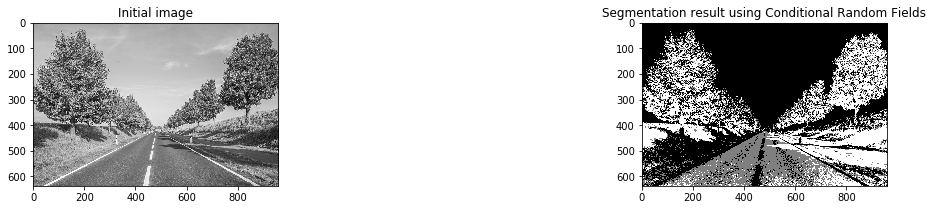

In [20]:
# load image
image_array_2 = misc.imread("test1.jpg", flatten=True)

# set figure size
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')

# segment input image
image_segmentation(image_array_2, image_info, max_iter=1e4, beta=1e6)